<a href="https://colab.research.google.com/github/hadizorkot331/AWS-Pokedex/blob/main/Project_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [584]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

# Load the dataset

In [585]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Molecules_Toxicity_Classification.xlsx")

#Data Exploration

In [586]:
data.shape

(159, 1205)

Visualizing Classes

In [587]:
data.dtypes

,0
Unnamed: 0,int64
MATS3v,float64
nHBint10,int64
MATS3s,float64
MATS3p,float64
...,...
nT5Ring,int64
SHdNH,float64
ETA_dEpsilon_C,float64
MDEO-22,float64


In [588]:
encoder = LabelEncoder()
data["Class"] = encoder.fit_transform(data["Class"])

data.dtypes

,0
Unnamed: 0,int64
MATS3v,float64
nHBint10,int64
MATS3s,float64
MATS3p,float64
...,...
nT5Ring,int64
SHdNH,float64
ETA_dEpsilon_C,float64
MDEO-22,float64


<Axes: xlabel='Class', ylabel='count'>

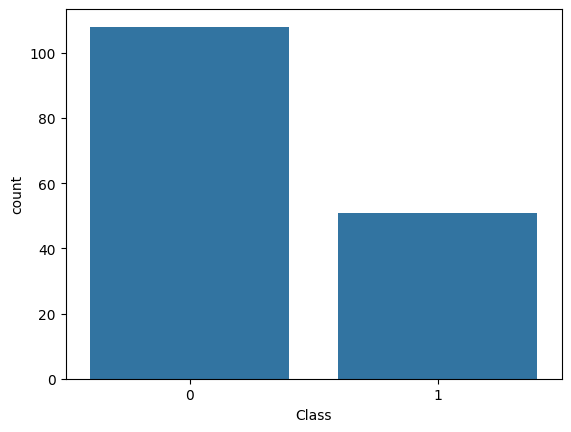

In [589]:
sns.countplot(data, x="Class")

In [590]:
X = data.drop("Class", axis=1)
y = data["Class"]

In [591]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.1, shuffle=True, random_state=42)

In [592]:
from imblearn.pipeline import Pipeline as ImbPipeline  # Correct pipeline to handle y
from imblearn.over_sampling import RandomOverSampler  # Correct oversampler

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('oversampling', RandomOverSampler(random_state=0)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=300)),
    ('classifier', LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", max_iter=1000, random_state=0))
])

In [593]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [594]:
params = {
    "feature_selection__k":np.arange(100, 400, 50),
    "classifier__C":[0.01, 0.1, 0.5, 1, 10],
}

In [595]:
grid_search = GridSearchCV(pipeline, params, scoring="roc_auc", cv=cv)

In [596]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  65   97  187  241  353  604  621  734  766  854  950 1035 1126 1165] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  65  204  215  241  254  353  379  604  621  703  760  766  990 1029
 1035 1036 1111 1126 1165] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univari

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('oversampling',
                                        RandomOverSampler(random_state=0)),
                                       ('feature_selection',
                                        SelectKBest(k=300)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           penalty='l1',
                                                           random_state=0,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.01, 0.1, 0.5, 1, 10],
                         'feature_selection__k': array([100, 150, 200, 250, 300, 350])},
             scoring='roc_auc')

In [597]:
grid_search.best_score_

0.8250877192982455

In [598]:
grid_search.best_params_

{'classifier__C': 0.1, 'feature_selection__k': 200}

In [599]:
lr = grid_search.best_estimator_

In [600]:
y_pred = lr.predict(X_test)

In [601]:
accuracy_score(y_test, y_pred)

0.75

In [602]:
f1_score(y_test, y_pred)

0.7142857142857143

In [603]:
recall_score(y_test, y_pred)

1.0

In [604]:
precision_score(y_test, y_pred)

0.5555555555555556

In [605]:
accuracy_score(y_train, lr.predict(X_train))

0.8461538461538461

In [606]:
RF_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('oversampling', RandomOverSampler(random_state=0)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=300)),
    ('classifier', RandomForestClassifier(max_depth=5, n_estimators=100, class_weight="balanced", random_state=0))
])

In [607]:
RF_params = {
    "feature_selection__k":np.arange(100, 400, 50),
    "classifier__max_depth":np.arange(10, 25, 5),
    "classifier__n_estimators":np.arange(100, 500, 100),
}

In [608]:
RF_grid_search = GridSearchCV(RF_pipeline, RF_params, scoring="roc_auc", cv=cv)

In [609]:
RF_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  65   97  187  241  353  604  621  734  766  854  950 1035 1126 1165] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  65  204  215  241  254  353  379  604  621  703  760  766  990 1029
 1035 1036 1111 1126 1165] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univari

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('oversampling',
                                        RandomOverSampler(random_state=0)),
                                       ('feature_selection',
                                        SelectKBest(k=300)),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=5,
                                                               random_state=0))]),
             param_grid={'classifier__max_depth': array([10, 15, 20]),
                         'classifier__n_estimators': array([100, 200, 300, 400]),
                         'feature_selection__k': array([100, 150, 200, 250, 300, 350])},
             scoring='roc_auc')

In [610]:
RF_grid_search.best_score_

0.8946783625730994

In [611]:
RF_grid_search.best_params_

{'classifier__max_depth': 10,
 'classifier__n_estimators': 400,
 'feature_selection__k': 100}

In [612]:
rf = RF_grid_search.best_estimator_

In [613]:
rf_y_pred = rf.predict(X_test)

In [614]:
accuracy_score(y_test, rf_y_pred)

1.0

In [615]:
f1_score(y_test, rf_y_pred)

1.0

In [616]:
recall_score(y_test, rf_y_pred)

1.0

In [617]:
precision_score(y_test, rf_y_pred)

1.0

In [618]:
accuracy_score(y_train, rf.predict(X_train))

1.0